[ AlexNet Image Classification Model ]

- 데이터셋 : ImageNet의 1000개 카테고리 이미지 사용
- 2012년 이미지 분류 모델 대회에서 우승 모델 ㄷㄷ

In [64]:
# [1] 모듈 로딩
import torch
from torchvision.models import alexnet, AlexNet_Weights
from torchinfo import summary

import torch.nn as nn                          # 인공신경망 관련
import torch.nn.functional as F                # 인공신경망 함수들 관련

import torchvision.datasets as datasets
import torchvision.transforms as transforms    # 이미지 전처리 변형 관련
from torchvision.datasets import CIFAR10       # 내장 데이터셋
from torch.utils.data import DataLoader   
from torch.utils.data import Subset, random_split
from torchvision.datasets import ImageFolder     

import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib

import os

In [65]:
# [2] 모델 인스턴스 생성
model = alexnet(weights='DEFAULT')

In [66]:
# [3] 모델 구조 확인
summary(model, input_size = (1,3,244,244))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 1000]                 --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 60, 60]           23,296
│    └─ReLU: 2-2                         [1, 64, 60, 60]           --
│    └─MaxPool2d: 2-3                    [1, 64, 29, 29]           --
│    └─Conv2d: 2-4                       [1, 192, 29, 29]          307,392
│    └─ReLU: 2-5                         [1, 192, 29, 29]          --
│    └─MaxPool2d: 2-6                    [1, 192, 14, 14]          --
│    └─Conv2d: 2-7                       [1, 384, 14, 14]          663,936
│    └─ReLU: 2-8                         [1, 384, 14, 14]          --
│    └─Conv2d: 2-9                       [1, 256, 14, 14]          884,992
│    └─ReLU: 2-10                        [1, 256, 14, 14]          --
│    └─Conv2d: 2-11                      [1, 256, 14, 14]         

In [67]:
# 모델 층 정보 추출
for name, param in model.named_parameters():
    print(name, param.shape)

features.0.weight torch.Size([64, 3, 11, 11])
features.0.bias torch.Size([64])
features.3.weight torch.Size([192, 64, 5, 5])
features.3.bias torch.Size([192])
features.6.weight torch.Size([384, 192, 3, 3])
features.6.bias torch.Size([384])
features.8.weight torch.Size([256, 384, 3, 3])
features.8.bias torch.Size([256])
features.10.weight torch.Size([256, 256, 3, 3])
features.10.bias torch.Size([256])
classifier.1.weight torch.Size([4096, 9216])
classifier.1.bias torch.Size([4096])
classifier.4.weight torch.Size([4096, 4096])
classifier.4.bias torch.Size([4096])
classifier.6.weight torch.Size([1000, 4096])
classifier.6.bias torch.Size([1000])


In [68]:
# [4] AlexNet 모델 사용을 위한 이미지 전처리
# AlexNet에서 요구하는 형태로 전처리가 이루어져야한다.
preprocessing = transforms.Compose(
    [
        transforms.Resize((256,256)),      # 크기 조정
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),             # (H,W,C) => (C, H, W) + 정규화 + 텐서화
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229,0.224,0.225])
    ])

In [69]:
# 사전학습 모델의 transform 인스턴스 추출
# transforms()
weights = AlexNet_Weights.DEFAULT
preprocess = weights.transforms()
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [70]:
# 사전학습 모델의 분류 클래스 정보 추출 
# meta 속성의 categories 키로 추출
classes = weights.meta['categories']
idx_to_class = dict(zip(range(1000), classes))
idx_to_class

{0: 'tench',
 1: 'goldfish',
 2: 'great white shark',
 3: 'tiger shark',
 4: 'hammerhead',
 5: 'electric ray',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich',
 10: 'brambling',
 11: 'goldfinch',
 12: 'house finch',
 13: 'junco',
 14: 'indigo bunting',
 15: 'robin',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel',
 21: 'kite',
 22: 'bald eagle',
 23: 'vulture',
 24: 'great grey owl',
 25: 'European fire salamander',
 26: 'common newt',
 27: 'eft',
 28: 'spotted salamander',
 29: 'axolotl',
 30: 'bullfrog',
 31: 'tree frog',
 32: 'tailed frog',
 33: 'loggerhead',
 34: 'leatherback turtle',
 35: 'mud turtle',
 36: 'terrapin',
 37: 'box turtle',
 38: 'banded gecko',
 39: 'common iguana',
 40: 'American chameleon',
 41: 'whiptail',
 42: 'agama',
 43: 'frilled lizard',
 44: 'alligator lizard',
 45: 'Gila monster',
 46: 'green lizard',
 47: 'African chameleon',
 48: 'Komodo dragon',
 49: 'African crocodile',
 50: 'American alligator',
 51: 'triceratops',
 

In [71]:
# 이미지 예측 테스트

# 이미지 경로 가져오기
IMG_DIR = './data/classification/'

IMG_LIST = os.listdir(IMG_DIR)
print(f'IMG_LIST => {IMG_LIST}')

IMG_LIST = [IMG_DIR + filename for filename in IMG_LIST if filename.endswith('.png')]
print(f'IMG_LIST => {IMG_LIST}')

IMG_LIST => ['귀여운 레서판다.png', '티니핑.jfif']
IMG_LIST => ['./data/classification/귀여운 레서판다.png']


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x1024 at 0x226AEF8BD90>
전처리 이후 shape : torch.Size([3, 224, 224])
shape 일치 이후 shape : torch.Size([1, 3, 224, 224])
torch.Size([1, 1000]) 387 lesser panda


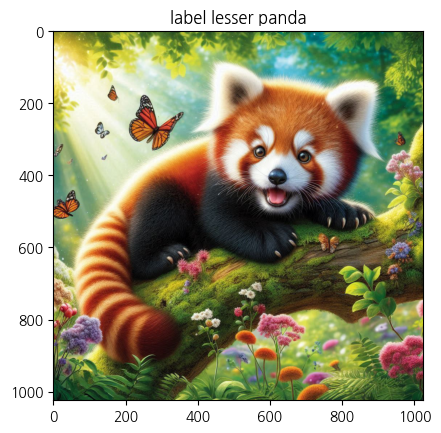

In [72]:
# 이미지 로딩 후 전처리
from PIL import Image

for imgfile in IMG_LIST:
    
    # 흑백 여부와 사이즈 확인
    img = Image.open(imgfile)
    print(img)
    
    # 동일 전처리
    trans_img = preprocess(img)
    print(f'전처리 이후 shape : {trans_img.shape}') 
    
    # shape 일치
    trans_img.unsqueeze_(0)
    print(f'shape 일치 이후 shape : {trans_img.shape}')  
    
    # 예측
    # pre 값들 중 가장 큰 값 
    pre = model(trans_img)
    pre_target = pre.max(dim=1)[1].item()
    print(f'{pre.shape} {pre_target} {idx_to_class.get(pre_target,"NONE")}')
    
    plt.imshow(img)
    plt.title(f'label {idx_to_class.get(pre_target,"NONE")}')
    plt.show()